# Projeto 1 

## 1 - Definição do problema de negócio 

<img width="633" height="112" style="display: block; margin-left: auto; margin-right: auto" src="https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png">

Queremos prever o preço de venda de um imóvel, e para isso utilizaremos um conjunto de dados históricos contendo algumas características dos imóveis (chamadas de variáveis preditoras) e o valor por qual ele foi vendido (SalePrice a variável alvo), no passado. 

Fonte dos dados: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

Obs: uma descrição de todas as variáveis está no anexo ao final deste notebook. 

## 2 - Pré-processamento dos dados 

Nesta estapa iremos realizar a **análise exploratória** dos dados e a uma **pré-preparação** dos dados para modelagem preditiva. 

### 2.1 - Análise exploratória 

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sea
import matplotlib.pyplot as plt
%matplotlib inline

# Divisão treino/teste 
from sklearn.model_selection import train_test_split

#### Importando dados 

In [2]:
df = pd.read_csv('dados/treino.csv')
print("Nº de registros: %d" % (df.shape[0]))
print("Nº de variáveis: %d" % (df.shape[1]))
df.head()

Nº de registros: 1460
Nº de variáveis: 81


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Verificando valores missing

In [3]:
df_missing = pd.DataFrame(df.isna().sum()[df.isna().sum() != 0].sort_values(ascending = False), columns = ["qtd_nan"])
df_missing['porcentagem'] = round(df_missing['qtd_nan']*100/len(df),1)
df_missing

,qtd_nan,porcentagem
PoolQC,1453,99.5
MiscFeature,1406,96.3
Alley,1369,93.8
Fence,1179,80.8
FireplaceQu,690,47.3
LotFrontage,259,17.7
GarageType,81,5.5
GarageYrBlt,81,5.5
GarageFinish,81,5.5
GarageQual,81,5.5


Removeremos as variáveis (colunas) cujo percentual de valores missing (NaN) seja maior que 40%. Assim sendo, as variáveis **PoolQC**, **MiscFeature**, **Alley**, **Fence** e **FireplaceQu** serão eliminadas. Também eliminaremos a variável **Id**, pois a mesma serve apenas para ordenação dos registros. 

In [4]:
df = df.drop(columns = 'Id')

In [5]:
df = df.drop(columns = df_missing[df_missing['porcentagem'] > 40].index)
df_missing = pd.DataFrame(df.isna().sum()[df.isna().sum() != 0].sort_values(ascending = False), columns = ["qtd_nan"])
df_missing['porcentagem'] = round(df_missing['qtd_nan']*100/len(df), 1)
df_missing

,qtd_nan,porcentagem
LotFrontage,259,17.7
GarageType,81,5.5
GarageYrBlt,81,5.5
GarageFinish,81,5.5
GarageQual,81,5.5
GarageCond,81,5.5
BsmtExposure,38,2.6
BsmtFinType2,38,2.6
BsmtQual,37,2.5
BsmtCond,37,2.5


Removeremos as linhas que contém valores missing nas variáveis cuja porcentagem seja inferior a **5.5%**. A variável **LotFrontage** receberá um tratamento diferenciado, seus valores missing serão substituídos pela média do valor da coluna, posteriormente.   

#### Divisão do dataframe em conjunto de dados de treino e teste

A partir deste ponto faremos as análises, tranformações e outros processos apenas nos dados definidos como **dados de treino**. Mas por que não fazer no conjunto inteiro ? Certos tratamentos dos dados podem influenciar, teoricamente, na capacidade de generalização do nosso futuro modelo, tornando-o tendencioso. Assim utilizaremos os dados de teste com mais eficiência e qualidade em nossa modelagem. 

A proporção definida foi de 70% dos dados para treino e 30% para teste. 

In [6]:
X = df.iloc[:,:-1]
Y = df['SalePrice']

x_treino, x_teste, y_treino, y_teste = train_test_split(X, Y, test_size = 0.30, random_state = 5)

df_treino = pd.DataFrame(x_treino, columns = X.columns)
df_treino['SalePrice'] = y_treino
df_treino.index = range(len(df_treino.index)) 

df_teste = pd.DataFrame(x_teste, columns = X.columns)
df_teste['SalePrice'] = y_teste
df_teste.index = range(len(df_teste.index)) 

Preenchendo os valores NaN da variável **LotFrontage** com a média dos valores da sua coluna nos **dados de treino** e removendo as demais linhas com valores missing das outras variáveis.

In [7]:
def fill_del_na(df, var):
    df[var].fillna(df[var].mean(), inplace = True)
    df = df.dropna()
    return df  

In [8]:
df_treino = fill_del_na(df_treino, 'LotFrontage')
print(df_treino.shape)
df_treino.head()

(936, 75)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,FV,75.000000,9803,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,226700
1,50,RL,60.000000,9084,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,3,2008,ConLw,Normal,95000
2,20,RL,64.000000,6762,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2007,New,Partial,195400
3,85,RL,70.116745,12122,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,7,2008,WD,Normal,178400
4,190,RL,60.000000,10800,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,5,2006,ConLD,Normal,160000


In [9]:
# Conferindo 
df_treino.isna().sum()[df_treino.isna().sum() != 0].sort_values(ascending = False)

Series([], dtype: int64)

Preenchendo os valores NaN da variável **LotFrontage** com a média dos valores da sua coluna nos **dados de teste** e removendo as demais linhas com valores missing das outras variáveis.

In [10]:
df_teste = fill_del_na(df_teste, 'LotFrontage')
print(df_teste.shape)
df_treino.head()

(402, 75)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,FV,75.000000,9803,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,226700
1,50,RL,60.000000,9084,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,3,2008,ConLw,Normal,95000
2,20,RL,64.000000,6762,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2007,New,Partial,195400
3,85,RL,70.116745,12122,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,7,2008,WD,Normal,178400
4,190,RL,60.000000,10800,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,5,2006,ConLD,Normal,160000


In [11]:
# Conferindo 
df_teste.isna().sum()[df_treino.isna().sum() != 0].sort_values(ascending = False)

Series([], dtype: int64)

#### Verificando o tipo das variáveis. 

Agora iremos verificar qual o tipo das variáveis do dataframe e dividi-las em variáveis **quantitativas** ou **qualitativas/categoricas**.

Também iremos verificar se alguma das variáveis quantitativas podem ser uma variável do tipo qualitativa, ou seja, a variável possui elementos numéricos discretos que representam informação qualitativa. 
Consideraremos uma variável que possui até **20 elementos numéricos discretos** como uma variável qualitativa, denominada **variável numérico categórica**.

In [12]:
# Do nosso dataframe original sem divisão treino/teste 

# Variáveis quantitativas  
quant_var = df.dtypes[df.dtypes != "object"].index
print("São %d variáveis quantitativas/numéricas." %(len(quant_var)))
# Variáveis qualitativas 
qual_var = df.dtypes[df.dtypes == "object"].index
print("São %d variáveis quantitativas/categóricas." %(len(qual_var)))

# Função para verificar quais são as variáveis numérico categóricas.

def num_cat_var(df, N):
    quant_var = df.dtypes[df.dtypes != "object"].index
    qual_var = df.dtypes[df.dtypes == "object"].index
    var_num_cat = []
    for var in quant_var:
        if(len(pd.unique(df[var])) <= N):
            var_num_cat.append(var)
    return var_num_cat

N = 20
print("O dataframe possui %d variáveis quantitativas que representam categorias." % (len(num_cat_var(df, N))))  

São 37 variáveis quantitativas/numéricas.
São 38 variáveis quantitativas/categóricas.
O dataframe possui 16 variáveis quantitativas que representam categorias.


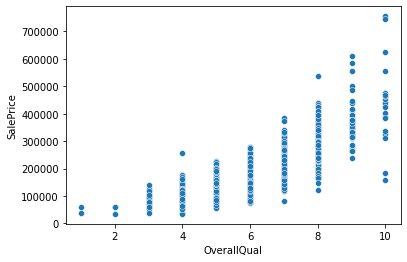

In [13]:
# Por exemplo, a variável OverallQual é numérica, mas representa categorias.
sea.scatterplot(data = df, x = 'OverallQual', y = 'SalePrice')
plt.show()

1) Plot de dispersão entre as **variáveis numérico-categóricas** e a variável alvo **SalePrice**

Com base nos gráficos, podemos notar que as variáveis **LowQualFinSF**, **3SsnPorch**, **PoolArea** e **MiscVal** são variáveis quantitativas (contínuas). Removeremos elas da lista de variáveis numérico categóricas.

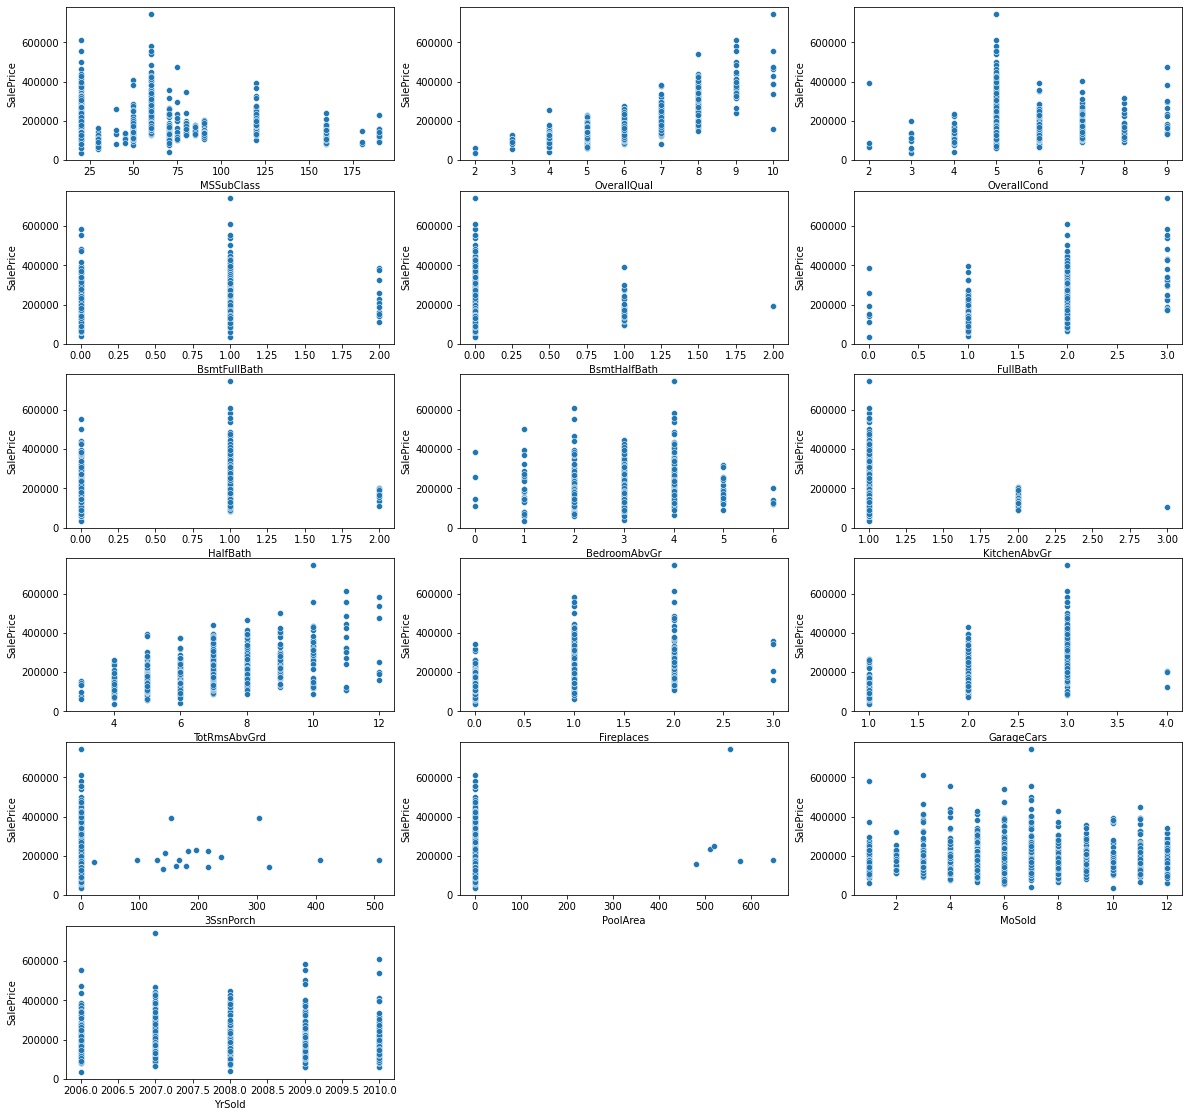

In [14]:
plt.figure(figsize = (20,40))
x = 1
for variavel in df_treino[num_cat_var(df, N)]:
    plt.subplot(12, 3, x)
    sea.scatterplot(data = df_treino, x = variavel, y = 'SalePrice')
    x += 1 

Agora iremos adicionar as variáveis **LowQualFinSF**, **3SsnPorch**, **PoolArea** e **MiscVal** na lista de variáveis quantitativas, e também remover as variáveis restantes da lista de variáveis numérico categóricas, na lista de variáveis quantitativas. Assim, teremos **apenas uma lista de variáveis quantitativas e uma lista de variáveis qualitativas**.

In [15]:
# Função que retorna uma lista de variáveis quantitativas e uma lista de variáveis qualitativas.

def total_var(df, lista, N):
    var_num_cat = [item for item in num_cat_var(df, N) if item not in lista]
    qual_var = list(df.dtypes[df.dtypes == "object"].index) 
    qual_var.extend(var_num_cat)

    quant_var = list(df.dtypes[df.dtypes != "object"].index) 
    quant_var.extend(lista)
    A = set(quant_var)
    B = set(var_num_cat)
    quant_var = list(A.difference(B))
    return quant_var, qual_var

In [16]:
variaveis = ['LowQualFinSF', '3SsnPorch', 'PoolArea', 'MiscVal']
qt, ql = total_var(df, variaveis, N)

print("Qtd de variáveis quantitativas = ", len(qt))
print("Qtd de variáveis qualitativas = ", len(ql))

Qtd de variáveis quantitativas =  23
Qtd de variáveis qualitativas =  52


2) Plot de dispersão entre as **variáveis qualitativas** e a variável alvo **SalePrice**

In [17]:
ql.append('SalePrice')

'SalePrice'

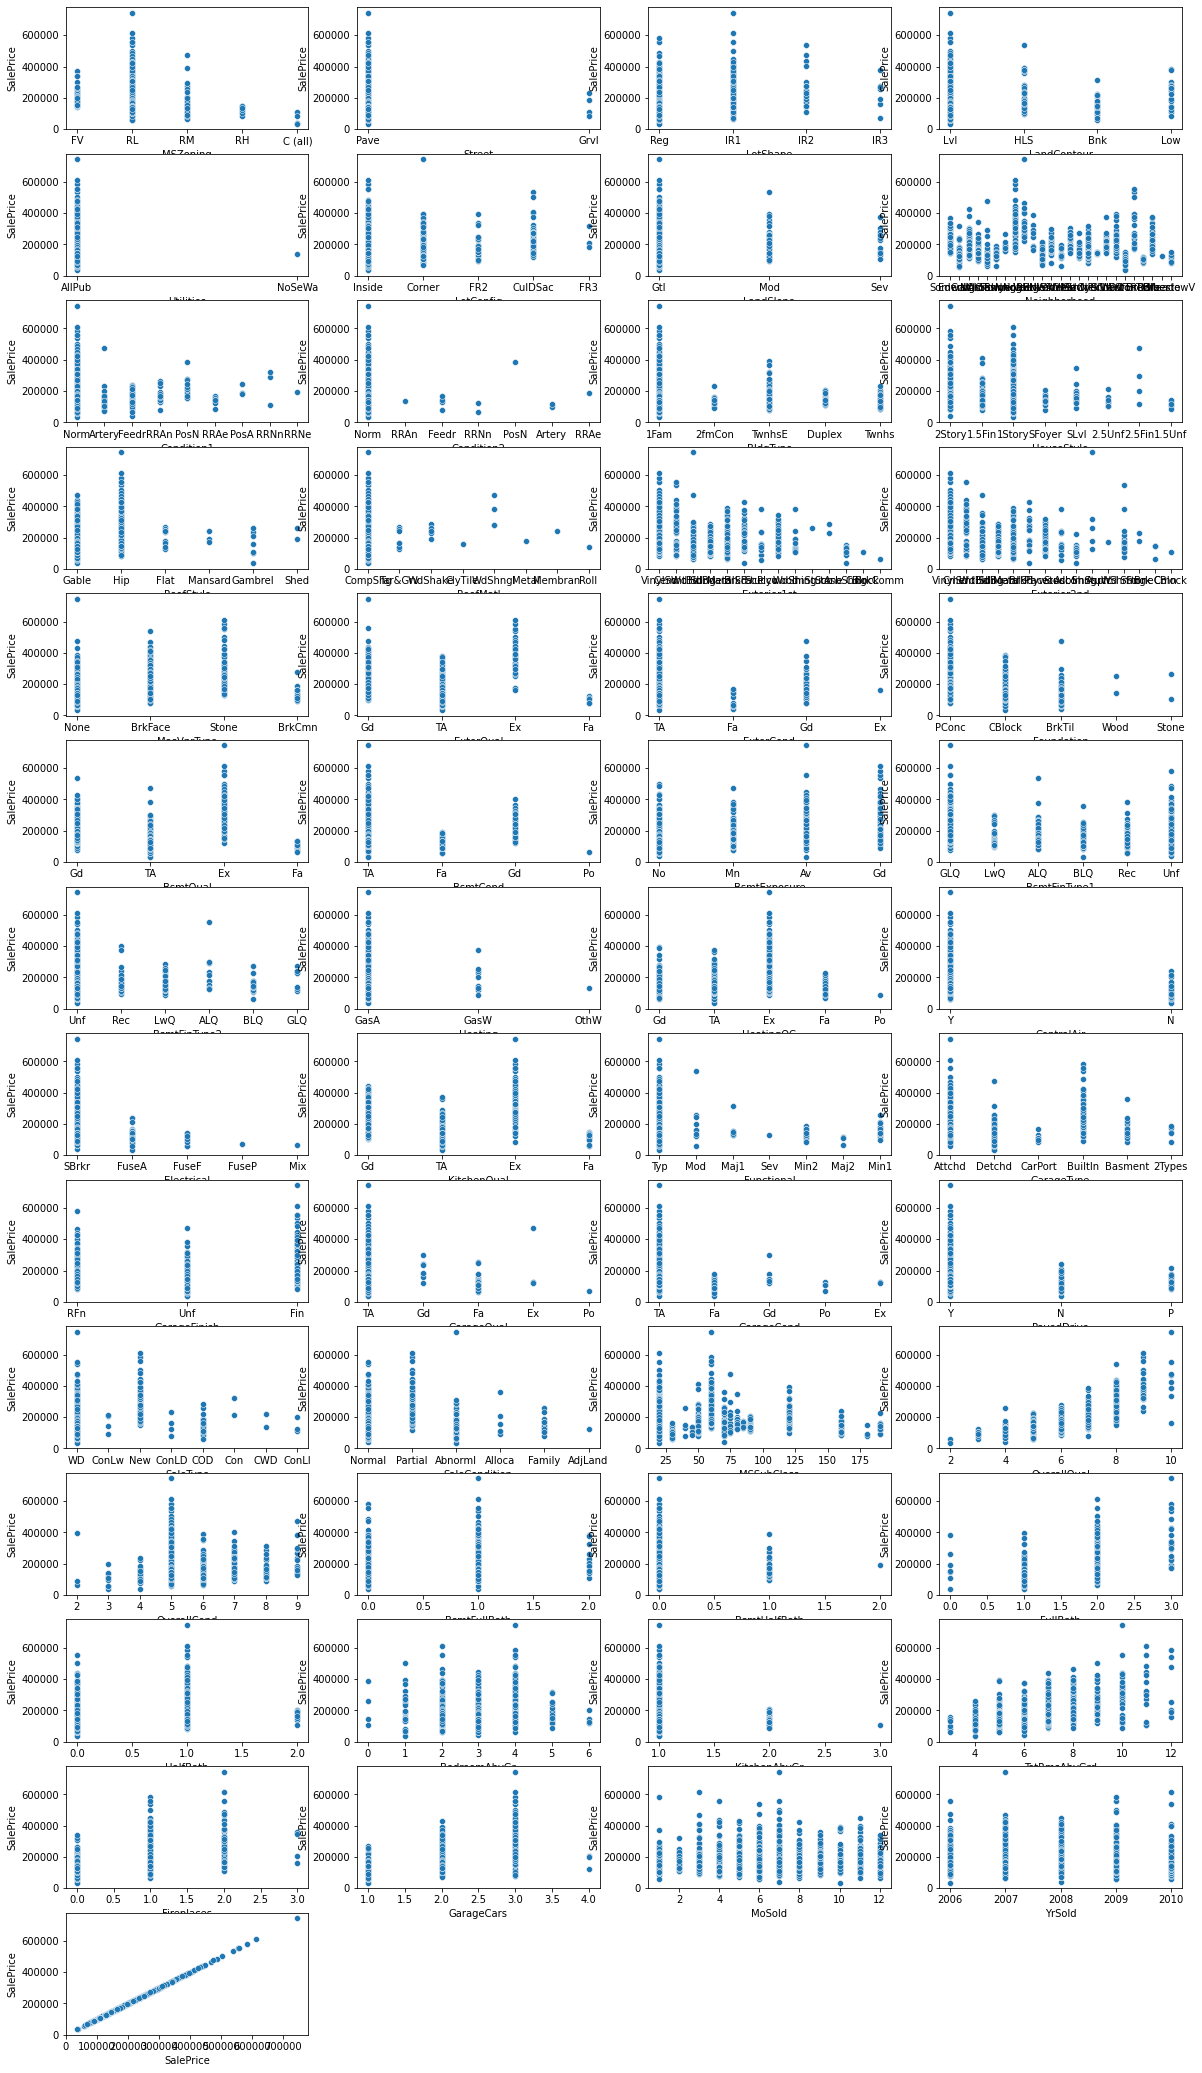

In [18]:
plt.figure(figsize = (20,40))
x = 1

for variavel in df_treino[ql]:
    plt.subplot(15, 4, x)
    sea.scatterplot(data = df_treino[ql], x = variavel, y = 'SalePrice')
    x += 1 
    
ql.pop()

Observando os gráficos acima, podemos verificar que todas as variáveis da lista ql são qualitativas/categóricas. 

 2) Plot de dispersão entre as **variáveis quantitativas** e a variável alvo **SalePrice**

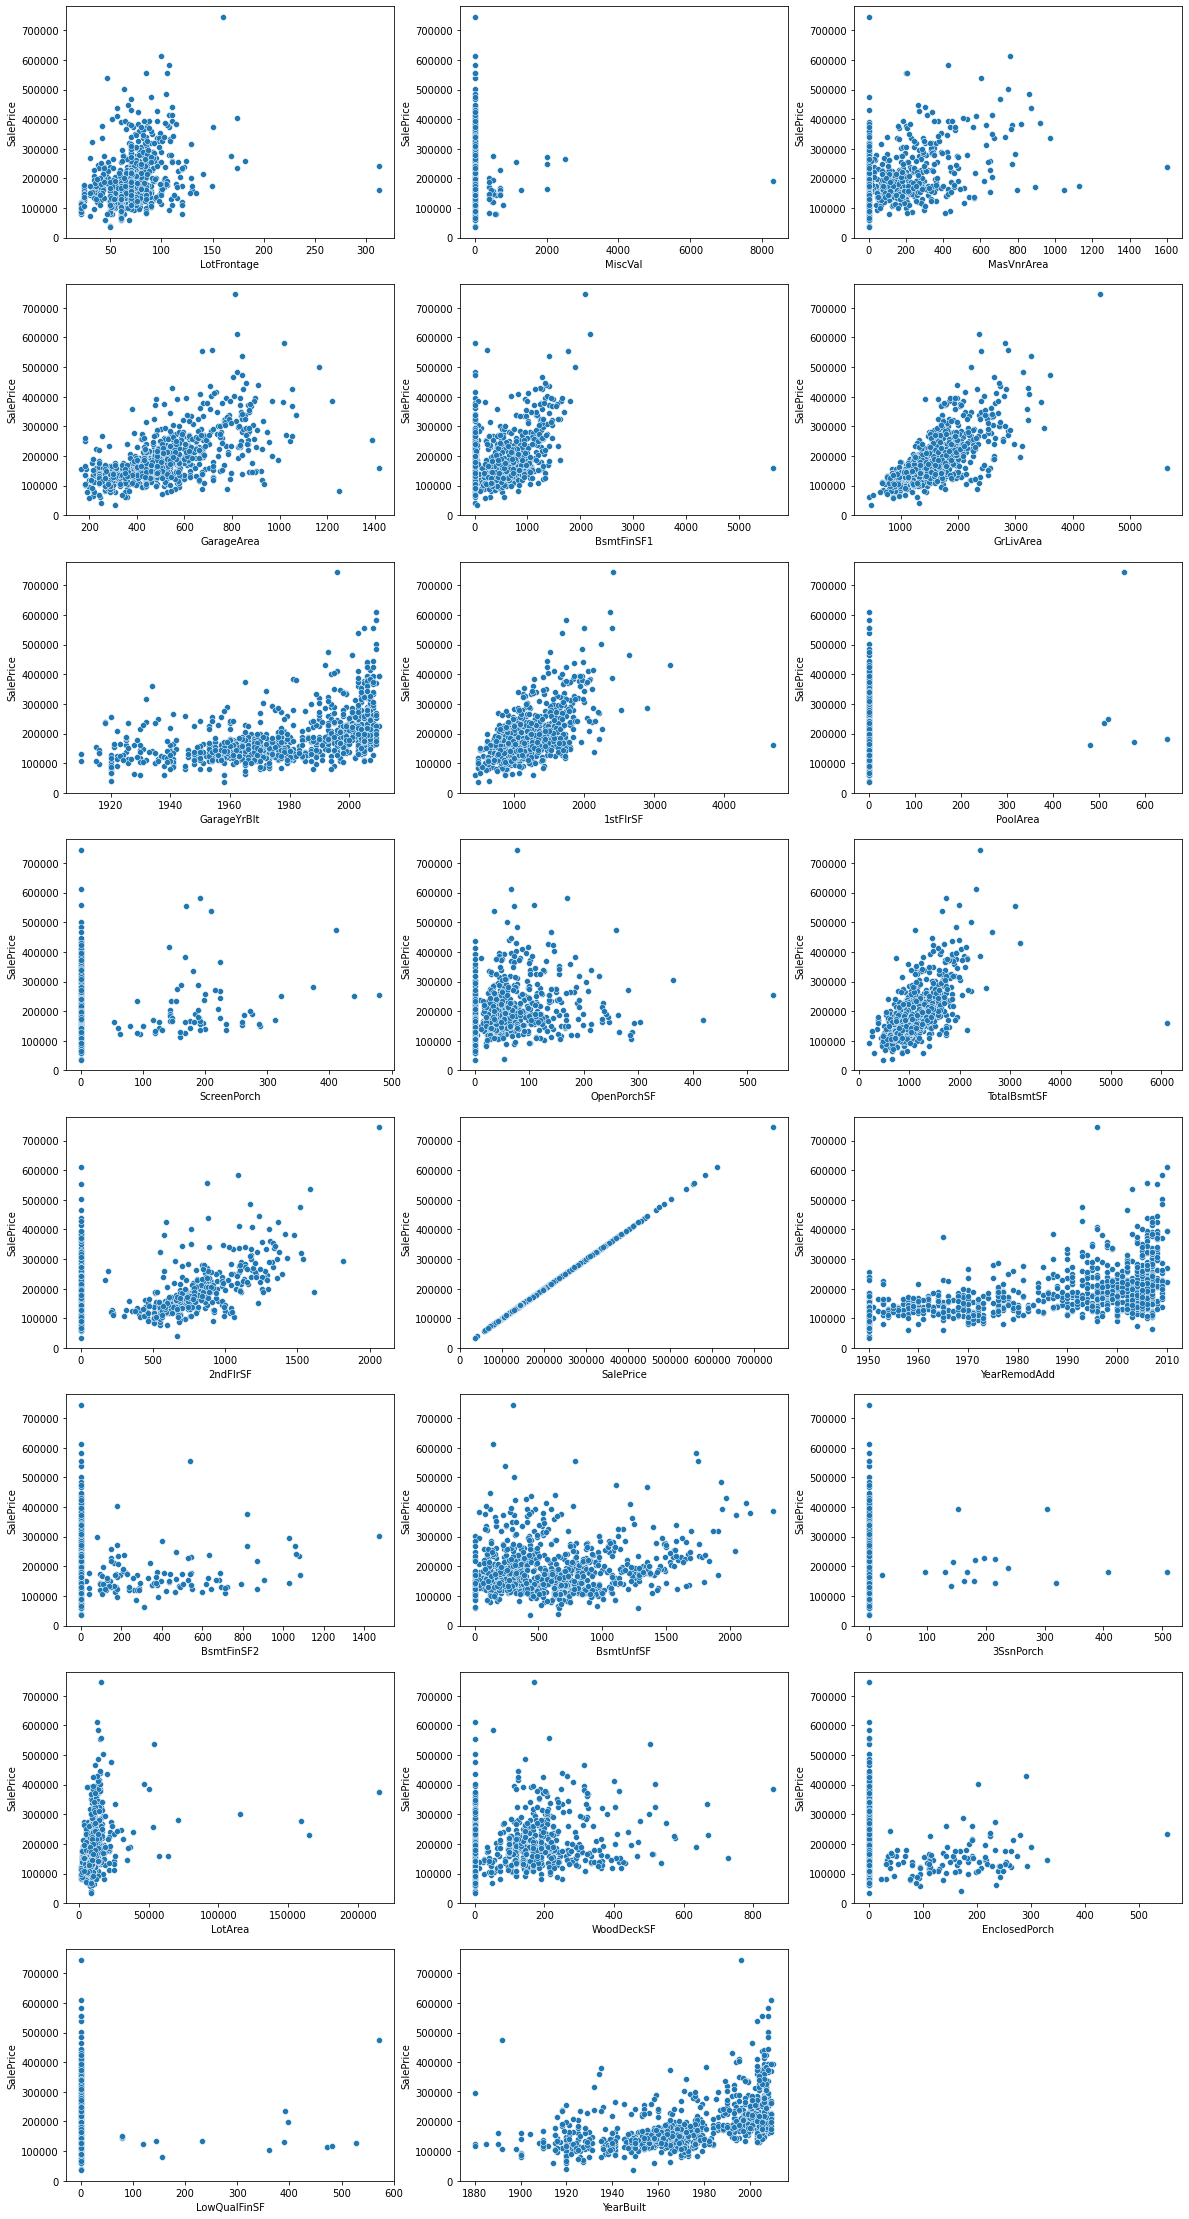

In [19]:
plt.figure(figsize = (20,40))
x = 1

for variavel in df_treino[qt]:
    plt.subplot(8, 3, x)
    sea.scatterplot(data = df_treino[qt], x = variavel, y = 'SalePrice')
    x += 1

### 2.1.1) Análise das variáveis quantitativas 

In [20]:
# Dimensões do conjunto de treino. 
df_treino[qt].shape

(936, 23)

Resumo estatístico básico 

In [21]:
df_treino[qt].describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
LotFrontage,936.0,70.8,23.4,21.0,60.0,70.1,80.0,313.0
MiscVal,936.0,34.2,320.7,0.0,0.0,0.0,0.0,8300.0
MasVnrArea,936.0,114.3,185.2,0.0,0.0,0.0,182.0,1600.0
GarageArea,936.0,504.7,190.3,164.0,367.8,484.0,596.5,1418.0
BsmtFinSF1,936.0,471.3,468.0,0.0,0.0,429.5,733.0,5644.0
GrLivArea,936.0,1544.9,528.6,438.0,1177.5,1482.0,1800.2,5642.0
GarageYrBlt,936.0,1978.5,24.9,1910.0,1961.0,1980.0,2002.0,2010.0
1stFlrSF,936.0,1186.5,398.3,438.0,899.2,1114.0,1419.8,4692.0
PoolArea,936.0,3.5,44.0,0.0,0.0,0.0,0.0,648.0
ScreenPorch,936.0,14.6,55.7,0.0,0.0,0.0,0.0,480.0


Medida de correlação entre as variáveis.

In [22]:
df_treino[qt].corr().round(1)

,LotFrontage,MiscVal,MasVnrArea,GarageArea,BsmtFinSF1,GrLivArea,GarageYrBlt,1stFlrSF,PoolArea,ScreenPorch,...,SalePrice,YearRemodAdd,BsmtFinSF2,BsmtUnfSF,3SsnPorch,LotArea,WoodDeckSF,EnclosedPorch,LowQualFinSF,YearBuilt
LotFrontage,1.0,0.0,0.2,0.4,0.2,0.4,0.1,0.4,0.2,0.0,...,0.3,0.1,0.0,0.1,0.1,0.3,0.0,0.1,0.0,0.1
MiscVal,0.0,1.0,-0.0,-0.0,0.0,0.1,-0.0,0.0,0.1,0.1,...,0.0,-0.0,0.0,-0.0,0.0,0.1,0.0,0.1,-0.0,-0.0
MasVnrArea,0.2,-0.0,1.0,0.4,0.3,0.4,0.3,0.3,0.0,0.1,...,0.4,0.2,-0.1,0.1,0.0,0.1,0.1,-0.1,-0.1,0.3
GarageArea,0.4,-0.0,0.4,1.0,0.3,0.5,0.6,0.5,0.1,0.0,...,0.6,0.4,-0.0,0.2,0.0,0.2,0.2,-0.1,0.0,0.4
BsmtFinSF1,0.2,0.0,0.3,0.3,1.0,0.2,0.2,0.5,0.2,0.0,...,0.4,0.1,-0.1,-0.5,0.0,0.2,0.2,-0.1,-0.0,0.2
GrLivArea,0.4,0.1,0.4,0.5,0.2,1.0,0.2,0.6,0.2,0.1,...,0.7,0.3,-0.0,0.2,-0.0,0.2,0.2,0.0,0.1,0.2
GarageYrBlt,0.1,-0.0,0.3,0.6,0.2,0.2,1.0,0.2,-0.0,-0.1,...,0.5,0.6,-0.1,0.2,0.0,-0.0,0.2,-0.3,-0.0,0.8
1stFlrSF,0.4,0.0,0.3,0.5,0.5,0.6,0.2,1.0,0.2,0.1,...,0.6,0.2,0.1,0.3,0.0,0.3,0.2,-0.0,-0.0,0.2
PoolArea,0.2,0.1,0.0,0.1,0.2,0.2,-0.0,0.2,1.0,0.1,...,0.1,0.0,0.1,-0.1,-0.0,0.1,0.0,0.1,0.1,0.0
ScreenPorch,0.0,0.1,0.1,0.0,0.0,0.1,-0.1,0.1,0.1,1.0,...,0.1,-0.0,0.1,-0.0,-0.0,0.0,-0.1,-0.1,0.1,-0.1


Medidas de forma 

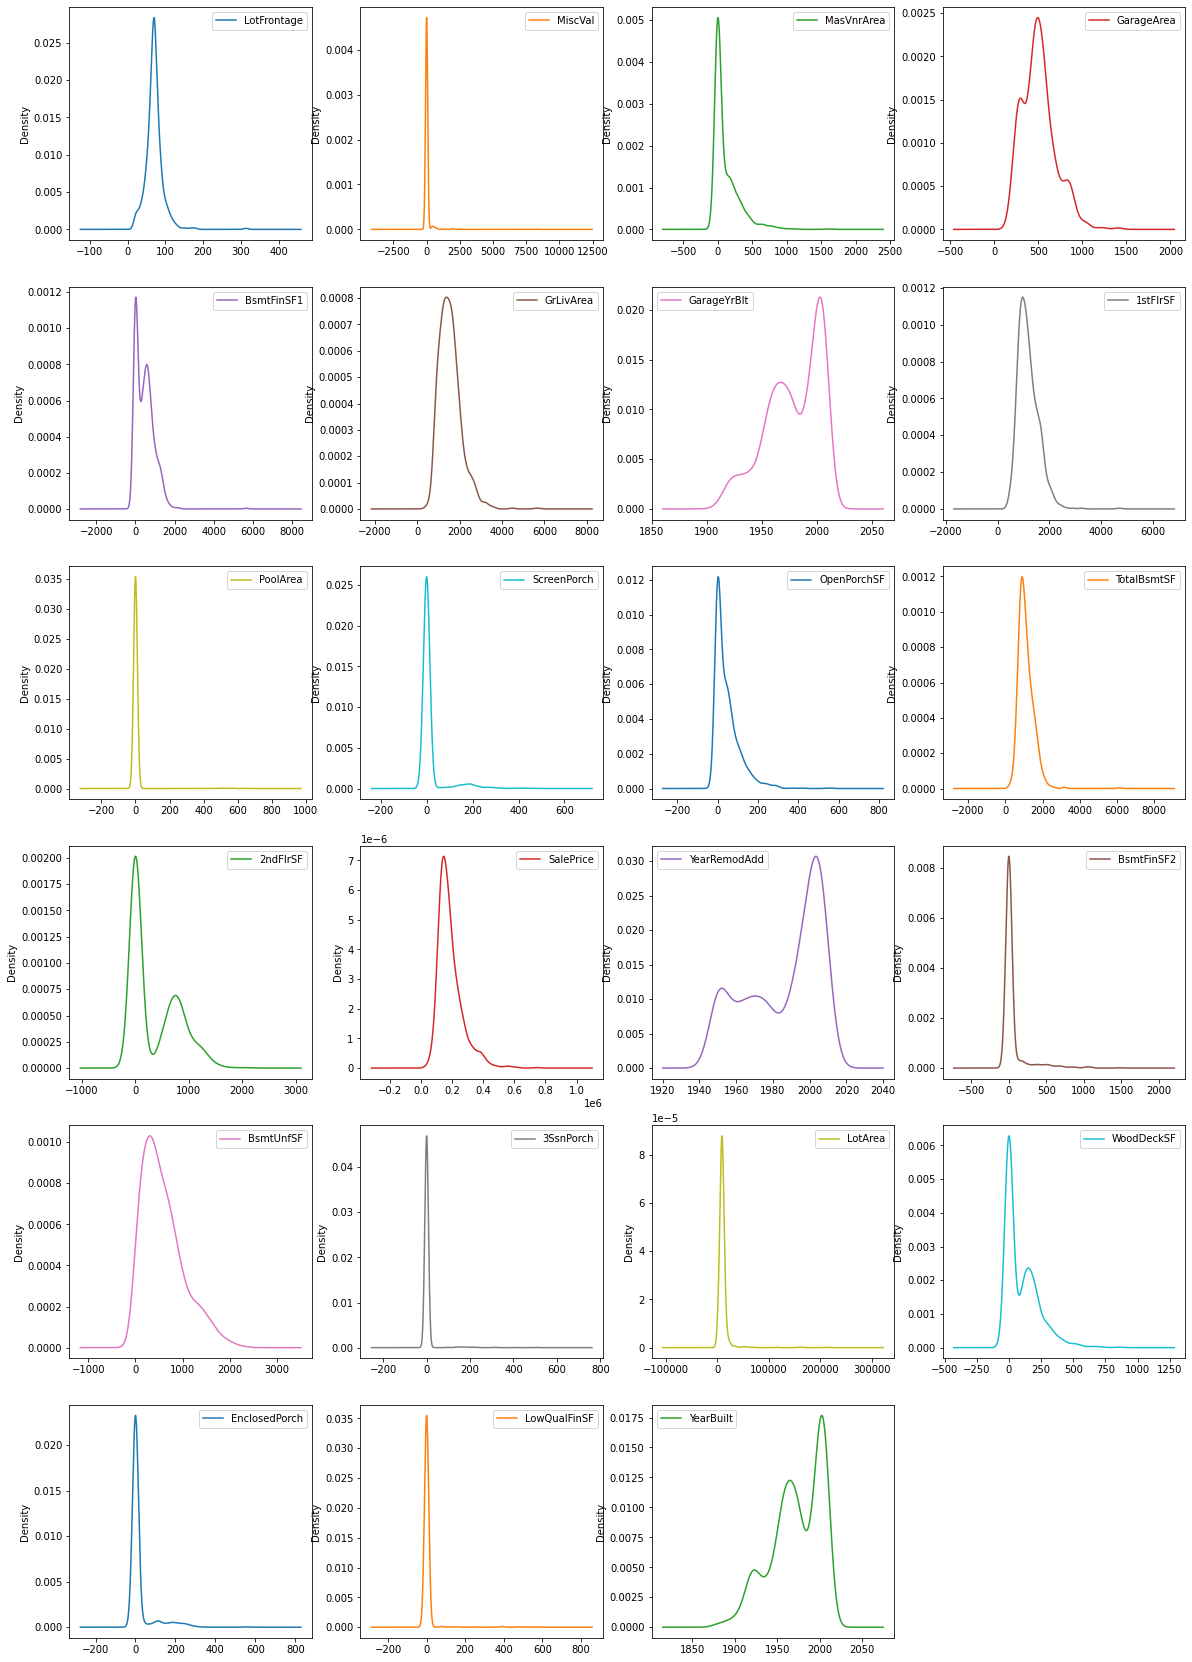

In [23]:
# O density plot facilita a visualização da distribuição dos dados.

df_treino[qt].plot(kind = 'density', figsize = (20,30), layout = (6, 4), subplots = True, sharex = False)
plt.show()

In [24]:
# Assimetria 
pd.DataFrame(df_treino[qt].skew() , columns = ['Assimetria']) 

,Assimetria
LotFrontage,2.879343
MiscVal,19.795960
MasVnrArea,2.415042
GarageArea,0.812925
BsmtFinSF1,1.996128
GrLivArea,1.402412
GarageYrBlt,-0.637057
1stFlrSF,1.504155
PoolArea,12.578882
ScreenPorch,4.318643


In [25]:
# Curtose
pd.DataFrame(df_treino[qt].kurt() , columns = ['Curtose']) 

,Curtose
LotFrontage,25.790471
MiscVal,480.724296
MasVnrArea,8.410391
GarageArea,1.141305
BsmtFinSF1,15.249897
GrLivArea,5.130659
GarageYrBlt,-0.513211
1stFlrSF,7.038211
PoolArea,158.250065
ScreenPorch,20.611826


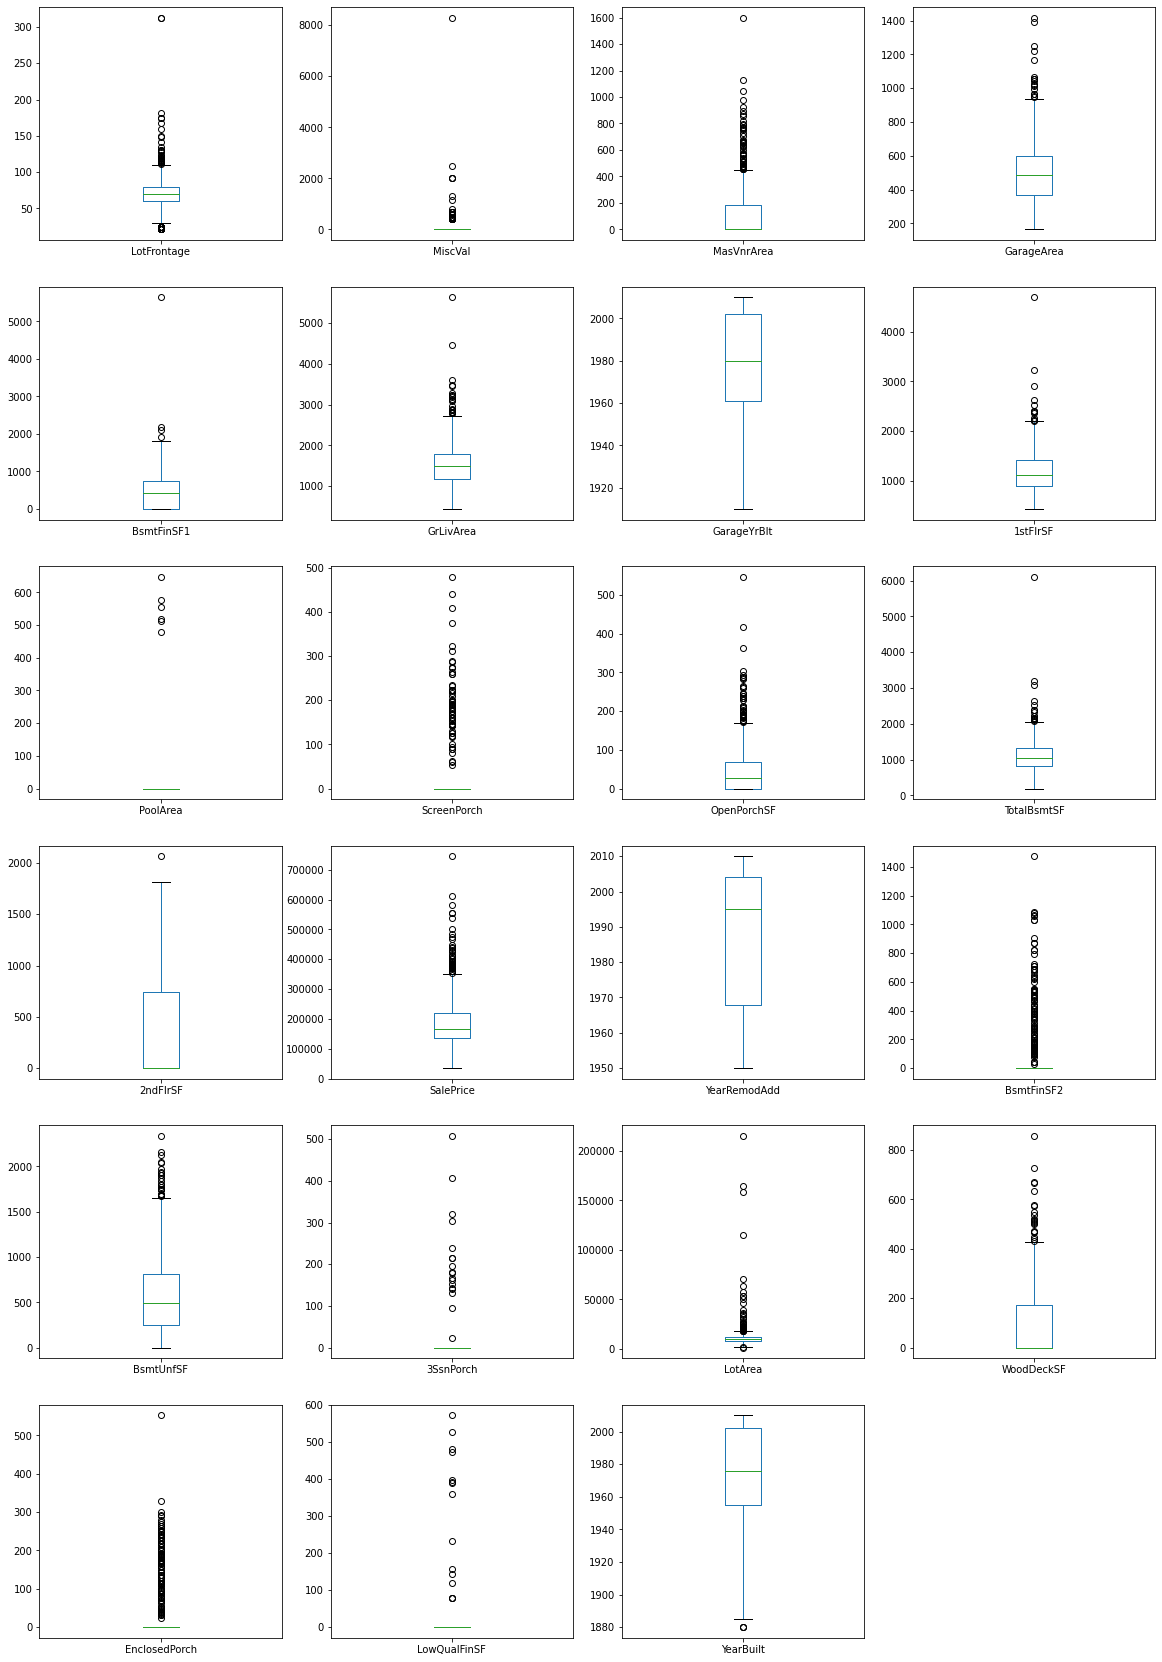

In [26]:
df_treino[qt].plot(kind = 'box', figsize = (20,30), layout = (6, 4), subplots = True, sharex = False)
plt.show()

In [27]:
# Função para informar sobre a quantidade de elementos acima do limite superior e abaixo do limite inferior de outliers. 

def qtd_outliers(df):
    # Função criada para retornar um dict com a qtd de outliers.
    # Retorna a qtd acima do lim sup e abaixo do lim inf. 
    dic = {}
    for i in df.columns:
    
        q3 = df[i].quantile(q = 0.75)
        q1 = df[i].quantile(q = 0.25)
        
        sup_outlier = q3 + (3/2)*(q3-q1) 
        inf_outlier = q1 - (3/2)*(q3-q1)

        qtd_sup = len(df[i][df[i] > sup_outlier])
        qtd_inf = len(df[i][df[i] < inf_outlier])
    
        dic[i] = [qtd_sup, qtd_inf]
    return dic 

# Dataframe com a qtq de outliers acima do limite superior e abaixo do limite inferior 

outliers = qtd_outliers(df_treino[qt])
tabela_outliers = pd.DataFrame(outliers, index = ['Superior', 'Inferior'])
tabela_outliers

,LotFrontage,MiscVal,MasVnrArea,GarageArea,BsmtFinSF1,GrLivArea,GarageYrBlt,1stFlrSF,PoolArea,ScreenPorch,...,SalePrice,YearRemodAdd,BsmtFinSF2,BsmtUnfSF,3SsnPorch,LotArea,WoodDeckSF,EnclosedPorch,LowQualFinSF,YearBuilt
Superior,33,31,53,18,4,24,0,13,6,71,...,46,0,113,24,18,45,21,115,15,0
Inferior,26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,3


#### Conclusão parcial 

Com base nas medidas estatísticas de **tendência central**, **dispersão**, **forma** e de **correlação** e na análise dos gráficos de **distribuição** e **boxplots** , notamos que:

    I) Algumas variáveis deverão receber uma tranformação para melhorar a distribuição dos dados (medidas de forma). 
    
    II) O dataframe deverá ser normalizado e/ou padronizado, afim de deixar todas as variáveis em uma escala comum. 

    III) Algumas variáveis serão analisadas em mais detalhes para definir se os valores extremos fazem sentido ou não (esta    etapa poderia ser feita com auxílio da área de negócio em um problema real).  
    
    IV) Outliers deverão ser tratados.
    
    V) Algumas variáveis possuem uma alta correlação e podem levar a multicolinearidade.  
    
Variáveis a serem analisadas em mais detalhes: **PoolArea**, **BsmtFinSF1**, **BsmtFinSF2**, **TotalBsmtSF**, **OpenPorchSF**, **GrLivArea**, **LotFrontage**, **3SsnPorch**, **ScreenPorch**, **MiscVal**, **EnclosedPorch**, **LowQualFinSF**, **LotArea**, **MasVnrArea**.           

#### Salvando análises e transformações.

In [28]:
df_treino.to_csv('dados/df_treino.csv', index = False)
df_teste.to_csv('dados/df_teste.csv', index = False)

### ANEXO 

#### Descrição das variáveis

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density
	
LotFrontage: Linear feet of street connected to property.

LotArea: Lot size in square feet

Street: Type of road access to property

       Grvl	Gravel	
       Pave	Paved
       	
Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
		
LotShape: General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular
       
LandContour: Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression
		
Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only	
	
LotConfig: Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property
	
LandSlope: Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope
	
Neighborhood: Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker
			
Condition1: Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
Condition2: Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
BldgType: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit
	
HouseStyle: Style of dwelling
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level
	
OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
	
OverallCond: Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor
		
YearBuilt: Original construction date

YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

RoofStyle: Type of roof

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed
		
RoofMatl: Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles
		
Exterior1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
	
MasVnrArea: Masonry veneer area in square feet

ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
ExterCond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
Foundation: Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood
		
BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

Heating: Type of heating
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace
		
HeatingQC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
CentralAir: Central air conditioning

       N	No
       Y	Yes
		
Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
		
1stFlrSF: First Floor square feet
 
2ndFlrSF: Second floor square feet

LowQualFinSF: Low quality finished square feet (all floors)

GrLivArea: Above grade (ground) living area square feet

BsmtFullBath: Basement full bathrooms

BsmtHalfBath: Basement half bathrooms

FullBath: Full bathrooms above grade

HalfBath: Half baths above grade

Bedroom: Bedrooms above grade (does NOT include basement bedrooms)

Kitchen: Kitchens above grade

KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       	
TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only
		
Fireplaces: Number of fireplaces

FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
		
GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
		
GarageYrBlt: Year garage was built
		
GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage
		
GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
PavedDrive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel
		
WoodDeckSF: Wood deck area in square feet

OpenPorchSF: Open porch area in square feet

EnclosedPorch: Enclosed porch area in square feet

3SsnPorch: Three season porch area in square feet

ScreenPorch: Screen porch area in square feet

PoolArea: Pool area in square feet

PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
		
Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
	
MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None
		
MiscVal: $Value of miscellaneous feature

MoSold: Month Sold (MM)

YrSold: Year Sold (YYYY)

SaleType: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
		
SaleCondition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
